# **Forecasting a Recession in the USA**
## __Part - 6__: Evaluation Metrics.

#### __The Story so far__

Aim of this project is to build a Machine Learning algorithm to predict the boom and bust cycle in the US economy and use this information for the purpouse of asset allocation. In the first part of this study I analyzed why recessions are important and how they affect returns in the Equity Market (SP500). The second chapter's focuses on the creation of our dataset and its EDA. In the third part I tackled the issue of dimensionality reduction by shortlisting two feature selection and extraction strategies (SelectFromModel with RandomForest and PCA) to be used later on in the construction of a ML pipeline. Then, in chapter four, I explored data scaling strategies and at the end of the analysis we selected a set scaler to apply in our analysis (QuantileTransformer and MinMaxScaler). In chapter V I analyzed and compared Cross Validation (CV) strategies to apply in our analysis and TimeSeriesSplit was selected as the best strategy given the nature of our research. The next step and the focus of this chapter is to select the evaluation metrics. 

#### _Index:_<a name="tol"></a>

6.1 [Evaluation Metrics: The Challenge Ahead;](#classprob)  
6.2 [Evaluation Metrics: A Field Experiment;](#field)       
6.3 [Trading Errors;](#trading)  
6.4 [Conclustion](#conc6)

## 6.1 Evaluation Metrics: The Challenge Ahead<a name="classprob"></a>

In chapter 5 I dropped a hint about the topic I tackle in this chapter: accuracy is not the best metric to assess model performances given the nature of the data available. __Unblanaced datasets__ pose a serius problem for classification task. Let's consider our target feature: the expansion periods outnumber recession one's by a ratio of 1:6. A dummy model that predicts expansion all the time would achieve an accuracy of 86% and at the same time being completely uncapable of predicting any recession. As a result, in identifing the metrics that will be used to evaluate a ML model, the class imbalace must be considered and whenever possible the preference should go towards measures that are not affected by that or that at least provide a better rapresentation than accuracy of the data.  

A second problem related to our analysis is that __not all the errors are equal__. This is a little more philosophical issue. When classifing the data between expansion and recession two kind of errors will occurs:
+ Some of the data are incorrectly classified as Recession (1 - positive class) when the real label is Expansion (0 - negative class), these are what in statistic are defined as _False Positive_ or _Type I Error_; and
+ Other data are incorrectly classified as Expansion (0 - negative class) when the real data is Recession (1 - positive class), these are what in statistic are defined as _False Negative_ or _Type II Error_.

All the other data will be correctly classified as Expansion when the label is Expansion (True Negative) or Recession when they really are Recession (True Positive). Going back to the errors, I stated that not all the errors are equal because Type I and Type II errors have different consequences. To understand this I first need to provide a general overview of what we are doing and the goal we are trying to achieve. In the first Chapter I explored the reasons why anticipating the occurance of a Recession is important. In particular I linked the Recession occurrances with the performances on the equity market (SP500) and I stressed how during recession the SP500 experiences negative returns on average while it deliveres positive performances during expansions. Therefore I introduced a simple model of asset allocation where a Fund would be fully invested in the risky asset class (SP500) during expansion and switch to safe assets (1 yr Treasury Bill) three months before a recession and to switch back to the risky asset three months before the end of the recession. The ML model I am trying to create is supposed to provide me the signal to switch from an asset class to the other, foreseeing a recession three months in advance.

Within the framework, I just outlined what are the consequence of the two types of error I described above? Every time the model produces a False Positive the Fund will be invested in the safe asset instead of the risky on: on average it will trade a higher positive return for a lower but still positive performance. When the ML Model incurrs in a false positive the asset allocation the Investor will experience a sure positive by giving up a uncertain higher positive return on average. On the other hand, when the model produces a False Negative the fund will be invested in the risky asset when it should be exposed to the safe one. In terms of performance the fund is giving away a sure positive return for an uncertain return that on average is negative (See Table.1 for some statistics on montly returns - not annualized).

<img src="Pictures/Table ret.PNG">  

At this point, investors attitude to risk should be considered: a general widespread assumption in finance is that investors exibit loss aversion and risk aversion. If this two conditions hold, the asset allocation brought about by the _False Positive/Type I_ errors (Recession is predicted but the actual outcome is Expansion) can still have some appeal for the investors: It swap an high expected returns with high volatility for a lower expected return with lower volatility and historical returns always positive. The narrative is dramatically different when the asset allocation derived from _False Negative/Type II_ errors (Expansion is predicted but the actual outcome is Recession). No rational investor that is both risk and loss averse would accept such an asset allocation: a low but positive expected return with low risk is traded for a negative expected return with higher risk.

On the basis of this analysis, it can be inferred that it is perfeclty rational to adopt an evaluation strategy that risk more false positives (Type I Errors) in exchange for more true positives.

To sum-up, I am looking for an evaluation metric that take in account these two factors:
+ __The Dataset is unbalanced__ - The negative class outnumber the positive; and
+ __Between Type I and Type II errors, the former is the lesser evil__.

The __Metric problem__ is fondamental in our analysis: __this is the key input that is used inside the GridSearch-CrossValidation in order to fine tune the models and find out the hyperparameters setting__.

The best way to study the evaluation problem is probably through an example on the ground. As a result I will fit and evaluate a Logistic Regression. But before proceeding here below you can find a quick refresh on some of the metrics that will be reported and metioned going forward:

$$
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
$$
  
$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

$$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

$$
\text{False Positive Rate - FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
$$

$$
\text{F} = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
$$

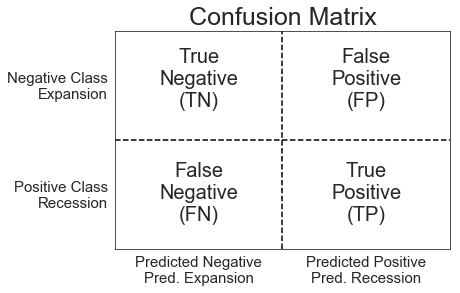

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
def plot_binary_confusion_matrix():
    plt.text(0.25, .65, "True\nNegative\n(TN)", size=20, horizontalalignment='center')
    plt.text(0.25, .125, "False\nNegative\n(FN)", size=20, horizontalalignment='center')
    plt.text(.75, .65, "False\nPositive\n(FP)", size=20, horizontalalignment='center')
    plt.text(.75, 0.125, "True\nPositive\n(TP)", size=20, horizontalalignment='center')
    plt.xticks([.25, .75], ["Predicted Negative\nPred. Expansion", "Predicted Positive\nPred. Recession"], size=15)
    plt.yticks([.25, .75], ["Positive Class\nRecession", "Negative Class\nExpansion"], size=15)
    plt.plot([.5, .5], [0, 1], '--', c='k')
    plt.plot([0, 1], [.5, .5], '--', c='k')

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title('Confusion Matrix',fontsize=25)
    plt.savefig('Pictures/Conf_matrix.png')
plot_binary_confusion_matrix()

## 6.2 Evaluation Metrics: A Field Experiment<a name="field"></a>

As first good step into sorting out the evaluation problem is trying to apply some evaluation metrics on a real example. Therefore I will train and test a KNN model within a pipeline and using a parameter set as outline here:
  
+ Data Scaler: QuantileTransformer-Uniform;
+ Features Selection: PCA - 16 Features;
+ Cross Validation: TimeSeriesSplit - 5 Folds;
+ n_neighbors: 5.

#### 6.2.1 CV Analysis and Confusion Matrix

Here the steps used to produce the cross validation results of the model described above:

1. After importing the usual set of libraries, functions and data, the single steps of the pipeline are created along a set of matrices and dictionaries used to store the results. Then the __TimeSeriesSplit Cross Validation analysis__ is performed. Since I want to explore the model results in details, I store the results of each CV-Fold predictions and its performance statistics. In the first place I analyze the Confusion Matrix of all the predictions done during the CV and those of each CV-fold. 

In [28]:
# Import all the required scalers 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
# import Personal Function
import myfunc_II as mf
from myfunc_II import plot_confusion_matrix, plot_ROC_curve_df, plot_ROC_curve_pp, make_confusion_matrix_imp
# import all the required models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.feature_selection import SelectFromModel
# Import Models Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
# Cross validation related libraries:
from sklearn.model_selection import (TimeSeriesSplit,StratifiedKFold)
from sklearn.metrics import auc, roc_curve, roc_auc_score, recall_score 
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, f1_score, classification_report, precision_recall_curve
# Pipeline Libraries
from sklearn.pipeline import Pipeline, make_pipeline
# generic libraries
from scipy import interp
import mglearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set_style("white")
np.set_printoptions(precision=4)

In [29]:
# import dataset
path_X_train='Data_from_prev_steps/X_train_data.csv'
path_y_train='Data_from_prev_steps/y_train_data.csv'
# Adjust Dates and Format
X_train=pd.read_csv(path_X_train, parse_dates=['Date'])
y_train=pd.read_csv(path_y_train, parse_dates=['Unnamed: 0'])
#X_train.rename(columns ={"Unnamed: 0":"Date"},inplace=True)
y_train.rename(columns ={"Unnamed: 0":"Date"},inplace=True)
X_train.set_index("Date",inplace=True)
y_train.set_index("Date",inplace=True)
y_train=y_train.values.ravel()

In [30]:
# Set prob Threshold
thresh_prob=0.5
# Set up the Pipeline Steps:
scaler=QuantileTransformer(output_distribution="uniform",n_quantiles=20)
feature=PCA(n_components=16)
model=LogisticRegression(C=0.1, solver='liblinear', penalty='l1',max_iter=5000)
cv=TimeSeriesSplit(n_splits=5)
# Create Pipeline:
pipe=Pipeline([("scaler",scaler),("feature_selection",feature),("Model",model)])
# Calculate all required output for the analysis:
y_v_50,y_p_50,y_v_mod,y_p_mod,results_yv_50,results_yp_50,results_yv_mod,results_yp_mod,cv_scores_50,cv_scores_mod=\
mf.conf_matrix_comparison_preparation_PB(X_train,y_train,cv=cv,model=pipe,mod_treshold=thresh_prob)

2. __The Confusion Matrix calculated__ on the join predictions of the 5-folds TimeSeriesSplit CV provides important insights into the model performance. 
    1. The high __accuracy__ score (88.2%) is only a result of the class imblance in the data. By predicting Expansion (the domainant class) most of the time the Model manage to achieve a high score in this metric;
    2. This trick is exposed by the __recall__ score. Most of the 'Recessions' are classified as 'Expansions'. Overall the Recall scores 34.7%: basically only one recession period out of three is calssified as such.  
    3. The model's bias to classify all the data as expansion is mirrowed into the __Precision Score__ (60.5%), significantly higher than the Recall.
    4. The Confusion matrix conveys an other important information: the Model commits too many mistakes of the worst case: __False Negative Errors outnumber False Positive__ by 47:20. 

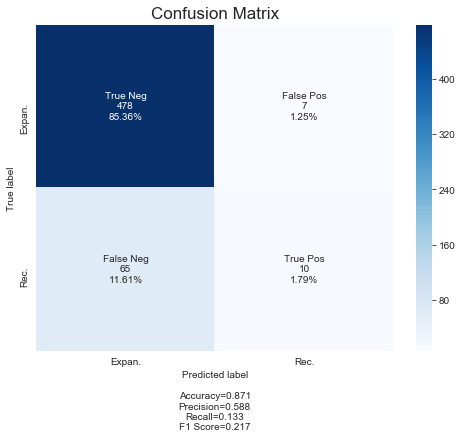

In [31]:
fig, axs = plt.subplots(figsize=(8,6))

mf.make_confusion_matrix(y_v_50, y_p_50,group_names=['True Neg','False Pos','False Neg','True Pos'],
                         categories=["Expan.", "Rec."],count=True,percent=True,cbar=True,xyticks=True,
                          xyplotlabels=True,sum_stats=True,figsize=(8,6),cmap='Blues',ax=axs,title="Confusion Matrix");

fig.savefig('Pictures/conf_matrix.png',dpi=75,bbox_inches='tight')

3. Some additional insight can be obtained by exploring the __Confusion Matrices and score of each of the 5 CV-Folds__:
    1. The Recession of CV-fold 3 seems particularly hard to detect,
    2. Overall Recall and Precision Metrics are somewhat volatile.
    3. The bias to commit more Type II errors over Type I is persistent in all CV Folds.

__Note__: The mean values of the scores presented here differ from the value presented before: While here below they are the average of all the scores obtained in the CV-Folds, before they were the scores calculated using all the forecast created in all the CV-Folds. 

,Accuracy,Recall,Precision,F1,Average Precision
0,91.071%,0.000%,0.000%,0.000%,8.929%
1,74.107%,3.704%,25.000%,6.452%,24.140%
2,79.464%,13.636%,42.857%,20.690%,22.808%
3,92.857%,0.000%,0.000%,0.000%,7.143%
4,98.214%,75.000%,100.000%,85.714%,76.786%
Mean_Values,86.620%,16.123%,30.873%,19.958%,25.984%


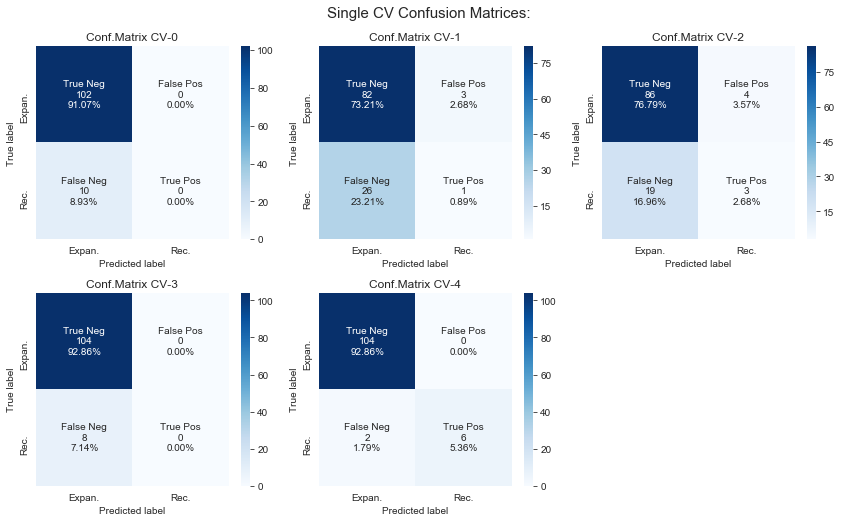

In [32]:
fig, axes = plt.subplots(2,3, figsize=(12,7));
axes=axes.ravel()
keys=list(results_yv_50.keys())
for ax,key in zip(axes,keys):
    mf.make_confusion_matrix(results_yv_50[key],results_yp_50[key],group_names=['True Neg','False Pos','False Neg','True Pos'],
                             categories=["Expan.", "Rec."],count=True,percent=True,cbar=True,xyticks=True,
                             xyplotlabels=True,sum_stats=False,figsize=None,cmap='Blues',ax=ax);
    ax.set_title('Conf.Matrix CV-{}'.format(key));

axes[5].set_axis_off();
fig.suptitle('Single CV Confusion Matrices:',y=1.03,fontsize=15);
fig.tight_layout();
fig.savefig('Pictures/all_conf_matrix.png',dpi=75,bbox_inches='tight')

display(cv_scores_50.loc[:,['Accuracy','Recall','Precision','F1','Average Precision']].style.format("{:.3%}"))

4. The quick analysis of the results coming from a very simple, untuned model as the one I just implemented are already insightful and confirmed some of the concernes I espressed in the past chapters:

    1. __Data Imbalance__ is a problem; 
    1. __Accuracy is an unrealiable metric__ for the problem we are facing; and
    1. When the Model shows too many Type II errors in comparison to Type I, the possibility to __trade the former for the latter__ is to be explored since False Negatives bear more severe consequences than False Positives.
    
In order to tackle these three points I need to introduce new performance measures.

#### 6.2.2 ROC and AUC Metrics

The Receiver Operating Characteristic (ROC) Curve plots together the true positive rates (Y-axis), and the false positive rate (X-axis) for various threshold values. The threshold value can either refer to the decision function or the predicted probabilities according to the model used. Ideally, if a model allows to reach the left top corner of the area graph, I would be able to achieve an error-free classification: a false positive rate of zero, and a True Positive Rate (Recall) of one.

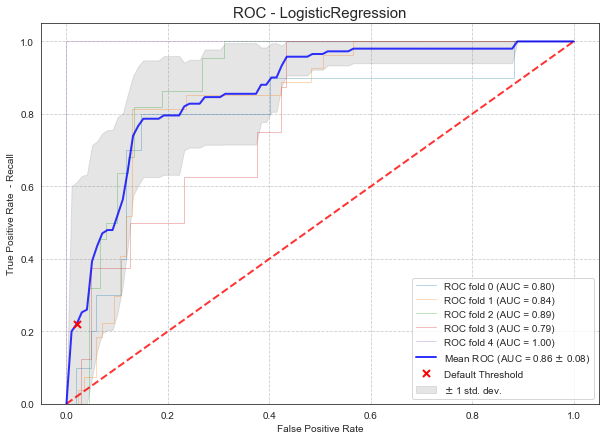

In [33]:
fig,ax=plt.subplots(figsize=(10,7))
mf.roc_cv_plot(X_train, y_train,cv=cv,model=pipe,ax=ax,mod_treshold=None, title='ROC - LogisticRegression')
fig.savefig('Pictures/ROC.png',dpi=75,bbox_inches='tight')

ROC curve conveys an additional key information: the Area Under the Curve (AUC). This is a key statistic since the closer its value is to 1 the closer the model is able to reach the top-left corner of the graph. The graph presented before already reported in the legend the AUC score for each CV-fold and the overall score, but for convenience I recap all the metrics used so far in this table:

In [34]:
display(cv_scores_50.style.format("{:.3%}"))

,Accuracy,Recall,Precision,F1,Average Precision,ROC-AUC
0,91.071%,0.000%,0.000%,0.000%,8.929%,79.804%
1,74.107%,3.704%,25.000%,6.452%,24.140%,83.660%
2,79.464%,13.636%,42.857%,20.690%,22.808%,88.889%
3,92.857%,0.000%,0.000%,0.000%,7.143%,78.606%
4,98.214%,75.000%,100.000%,85.714%,76.786%,100.000%
Mean_Values,86.620%,16.123%,30.873%,19.958%,25.984%,85.637%


The basic intuition that can be obtain from the ROC Curve is the trade off between the Type I and II errors. The steepest the ROC curve the lower the cost in terms of additional Type I errors that I need to pay to reduce the number of Type II errors. The __AUC measure is fundamental in the analysis__ since the highest its value, the steepest the ROC curve. 

__Conclusion__: The __Area Under the Curve__ (__AUC__) is the fondamental metric that I will use in the evaluation of Models' performances. It represents a gauge of how much costly is to trade false negative with false positive providing. Most and foremost, AUC is not distorted by the class imbalance An other metric must be considered is the __Recall Score__: it depicts how many recessions periods the model is able to spot out of all the recession periods and as a result the impact of the Type II errors (the bad one!). Worth considering, but to some extent subordinated to the other two, it is the __Precision Score__ that will provide an assessement of the Type I error.    

## 6.3 Trading Errors<a name="trading"></a>

In this section I will explore how empiracally I "trade" false negative (Type II) for false positive (Type I) errors. While doing that I define also some rules that I will use in the process of fine tuning and evaluationg the models. For the sake of clarity and simplify the graphic representation of what I am going to do I use a synthetic dataset created for this purpose. To achieve the goal of reducing False Negative errors while accepting higher False Positive I will use two strategies:

* Strategy 1: __Change the threshold for Prediction__
* Strategy 2: __Adjust the loss function__

When possible both strategies will be used. Before proceeding here below I show the synthetic data that I use:

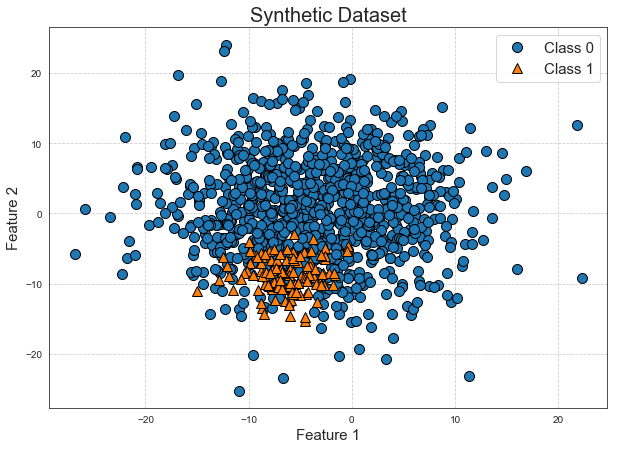

In [49]:
from sklearn.datasets import make_blobs
A, b=make_blobs(n_samples=(1000,120),cluster_std=[7.0,2.5],random_state=17)
A=pd.DataFrame(A)
fig,ax=plt.subplots(figsize=(10,7))
mglearn.discrete_scatter(A.iloc[:,0],A.iloc[:,1],b,ax=ax)
ax.grid(linestyle='--')
ax.set_title('Synthetic Dataset',fontsize=20)
ax.legend(["Class 0", "Class 1"],fontsize=15)
ax.set_xlabel('Feature 1',fontsize=15)
ax.set_ylabel('Feature 2',fontsize=15);
fig.savefig('Pictures/synthetic1.png')

#### Strategy 1: __Change the threshold for Prediction__

When a model makes a prediction it computes a probability based on the values variable avialable and if the probability is above 50% a specific point will be classified as belonging to the _Class 1_ or if below 50% it will be classified as _Class 0_. By changing the 50% threshold by reducing it I am increasing the number of points that wil be classified as Class 1. Techinically within the confusion matrix the classification will move from left to right. I show the effect by training a SVC with rbf kernel.

----
__Techinical Note__: The classification threshold can be modified either by working on the decision function or the predicted probablility. Whenever available, the latter will be used and the former as a back-up. 

----

In this example first I show the confusion matrix when using the default threshold, 0 (SVC Models rely on decision function, where the standard threshold is O), and then I recalculate the same confusion matrix by moving the threshold down to -0.95 (Left Confusion Matrix). As the statistics reported under the matrix show, even if the accuracy barely changed, from 0.917 to 0.905, the classification output experienced a massive movement in the Recall Score: from 0.542 to 0.858. At the same time precision score declined from 0.631 to 0.536. Moving the threshold allowed the model to increase the correct classification of the Class 1 and False Negatives decreased from 55 to 17 with a corresponding increase in the True Positives. However, the cost to pay for achieving this is an increase in the False Positive, from 38 to 89 and a equal decline in the True Negative. I traded Type II for Type I errors.    

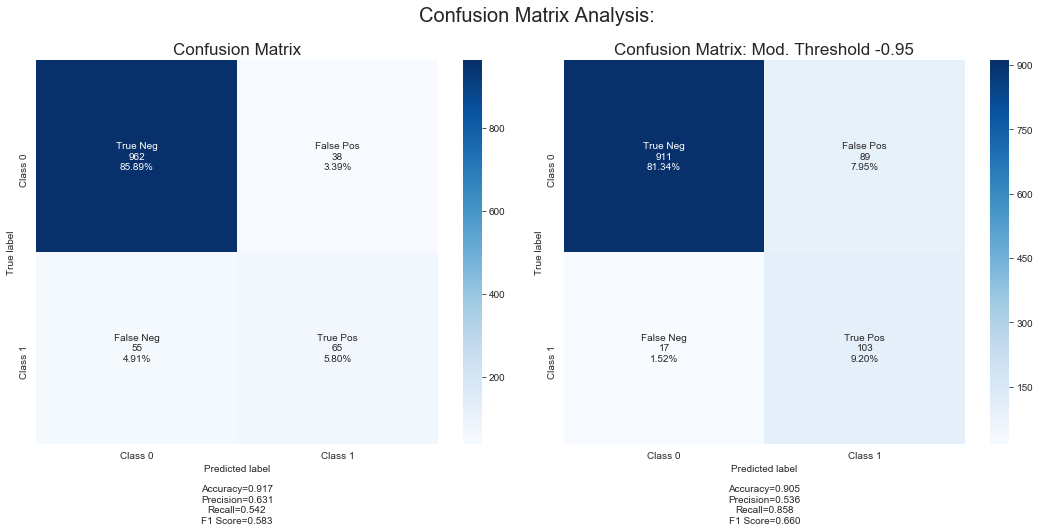

In [50]:
# Initializa model:
model_synt=SVC(kernel='rbf',C=1,gamma=0.1,probability=True)
cv=StratifiedKFold(n_splits=5)
thresh_prob=-0.95
fig, axs = plt.subplots(1,2,figsize=(15,7))
# Create all the Data to plot the Confusion Matrices
y_v_50,y_p_50,y_v_mod,y_p_mod,results_yv_50,results_yp_50,results_yv_mod,results_yp_mod,cv_scores_50,cv_scores_mod = \
mf.conf_matrix_comparison_preparation(X=A,y=b,cv=cv,model=model_synt,mod_treshold=thresh_prob)
# Plot the Confusion Matrices
mf.make_confusion_matrix(y_v_50, y_p_50,group_names=['True Neg','False Pos','False Neg','True Pos'],
                         categories=["Class 0", "Class 1"],count=True,percent=True,cbar=True,xyticks=True,
                         xyplotlabels=True,sum_stats=True,figsize=(8,6),cmap='Blues',ax=axs[0],title="Confusion Matrix");
mf.make_confusion_matrix(y_v_mod, y_p_mod,group_names=['True Neg','False Pos','False Neg','True Pos'],
                         categories=["Class 0", "Class 1"],count=True,percent=True,cbar=True,xyticks=True,
                         xyplotlabels=True,sum_stats=True,figsize=(8,6),cmap='Blues',ax=axs[1],
                         title="Confusion Matrix: Mod. Threshold {}".format(thresh_prob));
fig.suptitle('Confusion Matrix Analysis:',fontsize=20,y=1.05)
fig.tight_layout();
# Save the pictures
fig.savefig('Pictures/synthetic2.png',dpi=75,bbox_inches='tight')

How much expensive is this trade? To understand this it is usefull to look at the ROC curve. The default threshold is marked by a yellow X while the modified one by a red circle. I moved along a section of the ROC curve that is pretty steep so overall the total number of errors increased only marginally. The same graph tells us that from now on the ROC curve flattens out: if I want to increase the recall score any further, the price in terms of type I errors is going to be massive.

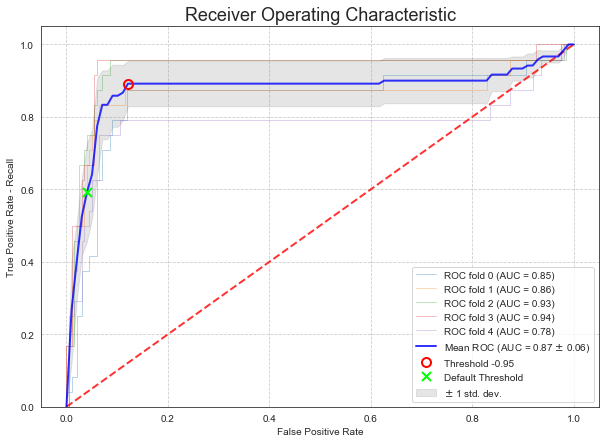

In [51]:
fig, axs = plt.subplots(figsize=(10,7))
mf.roc_cv_plot_df(A,b,cv,model_synt,ax=axs,mod_treshold=thresh_prob,title='Receiver Operating Characteristic',fontsize=18)
fig.savefig('Pictures/synthetic3.png',dpi=75,bbox_inches='tight')

Since I am working with only two features,  it's also possible to provide a 2D rapresentation of what I have done. Graphically I have expanded the area, marked by a bold black line, defined by values of the two features where our sample is classified as Class 1, as shown in Fig. X.

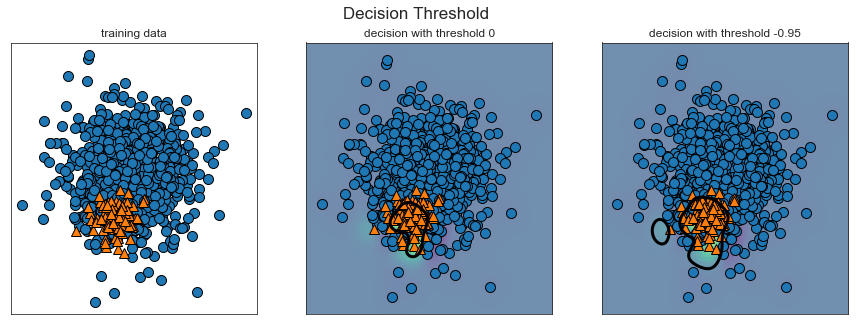

In [52]:
mf.plot_decision_threshold(A,b)

In general as I am trying to maximize the Recall Score, it can be usefull to set up a maximum value of FPR (False Positive Rate) that can be accepted. This will simplify the comparison among the models. For the purpose of this analysis I set this value at 15% of the total nummber of the False Positive errors. Going back to the original dataset, Since in the CV analysis we have 485 observation labelled as Expansion, I will __tolerate that no more of 73 Expansion Periods to be classified as Recession__. As a result, __I will increase the Recall Ration as much as possible as long as the FPR score si below 15% or, in different worlds, the number of false positive does not exceed 73__.   

#### Strategy 2: __Adjust the loss function__.

Some classifiers have an optional “class weights” parameter. Class weights can be used to adjust the loss function so that a model will not optimize by getting correct predictions on the majority class only. Class weights are assigned using a dictionary with the ratio desired or can be set as 'balanced'. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. Going forward, if not differently specified, the 'balanced' option is used.

Strategy 1 and 2 are not supposed to be indipendet but to work together when possible. Here the same analysis on the confusion matrix is carried out with the only difference that the model has the "Class Weights" attribute on. Again the dataset used is the synthetic one to facilitate the analysis. 

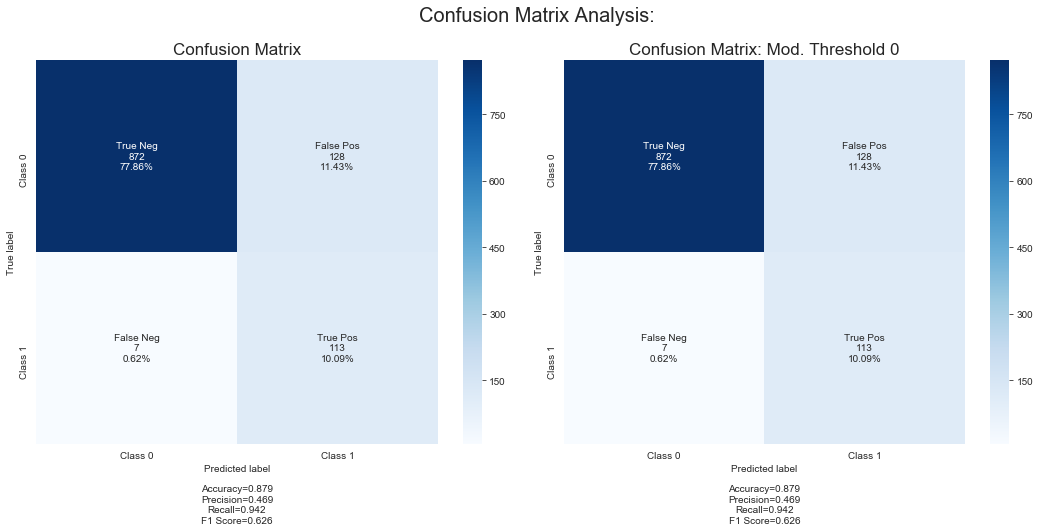

In [53]:
# Initiate Models:
model_synt=SVC(kernel='rbf',C=1,gamma=0.1,probability=True,class_weight='balanced')
cv=StratifiedKFold(n_splits=5)
thresh_prob=-0
fig, axs = plt.subplots(1,2,figsize=(15,7))
# Create all the Data to plot the Confusion Matrices
y_v_50,y_p_50,y_v_mod,y_p_mod,results_yv_50,results_yp_50,results_yv_mod,results_yp_mod,cv_scores_50,cv_scores_mod = \
mf.conf_matrix_comparison_preparation(X=A,y=b,cv=cv,model=model_synt,mod_treshold=thresh_prob)
# Plot the Confusion Matrices
mf.make_confusion_matrix(y_v_50, y_p_50,group_names=['True Neg','False Pos','False Neg','True Pos'],
                         categories=["Class 0", "Class 1"],count=True,percent=True,cbar=True,xyticks=True,
                         xyplotlabels=True,sum_stats=True,figsize=(8,6),cmap='Blues',ax=axs[0],title="Confusion Matrix");
mf.make_confusion_matrix(y_v_mod, y_p_mod,group_names=['True Neg','False Pos','False Neg','True Pos'],
                         categories=["Class 0", "Class 1"],count=True,percent=True,cbar=True,xyticks=True,
                         xyplotlabels=True,sum_stats=True,figsize=(8,6),cmap='Blues',ax=axs[1],
                         title="Confusion Matrix: Mod. Threshold {}".format(thresh_prob));
fig.suptitle('Confusion Matrix Analysis:',fontsize=20,y=1.05)
fig.tight_layout();
# Save the pictures
fig.savefig('Pictures/synthetic5.png',dpi=75,bbox_inches='tight')

In this case I decided to not tinker with the threshold level and leave it at the default value of 0. Indeed, the model shows already satisfactory levels in the recall score, while the ROC curve, presented in the next picture, signals that further improvements in this metric will come at a considerable cost, as the curve flattens out from now on.

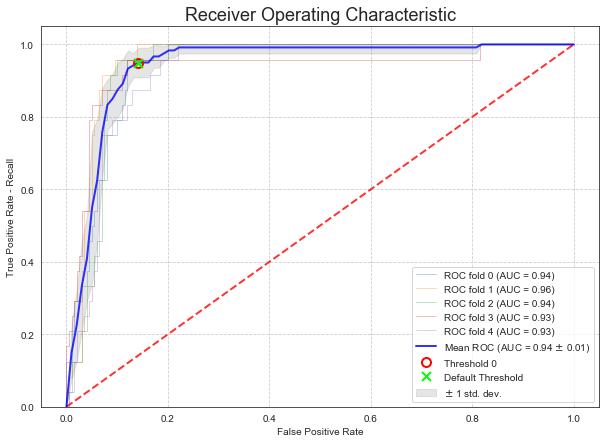

In [54]:
fig, axs = plt.subplots(figsize=(10,7))
mf.roc_cv_plot_df(A,b,cv,model_synt,ax=axs,mod_treshold=thresh_prob,title='Receiver Operating Characteristic',fontsize=18)
fig.savefig('Pictures/synthetic6.png',dpi=75,bbox_inches='tight')

## 6.4 Conclusions<a name="conc6"></a>

In this chapter I have explored how I plan to evaluate ML models' performance in the classification problem I am studying. In the first part I have outlined the problems I am facing, they can be accredited to two origins:

* The __unbalanced nature of the data__: expansion periods outnumber recession periods; and
* __Difference in Errors' consequences__: the effects, in terms of investement decision, of Type II errors (recessions classified as expansions) are more serious that the outcomes from Type I errors (expansions classified as expansions).

Then the chapter moved on idetifing the solution to the problem raised. In the first place I identified an evaluation metric that is not affected by the data imbalance. As a result the __Area Under the Curve__ (AUC) of the  Receiver Operating Characteristic (ROC). This metric selection is very important as it is the loss/utility function that will be used inside the GridSearch Cross Validation in order to fine-tuning the models' hyperparameters.

Then, in order to address the second issue I identified two strategies to reduce the number of Type II error by accepting an higher frequency of Type I error:

* __Change the Prediction Threshold__; and
* __Adjust the loss function__.

The first one is going to be implemented on all the model that I study, while the second will be used only in those models that have the 'Class Weight' parameter available. In trading False Negative (Type II) errors for False Positive (Type I), I also defined an __upper ceiling on the total number of False Positive I am ready to accept as measured in terms of False Positive Rate (FPR): 15%__. 